Ya hemos realizado un análisis exploratorio durante la primera parte del trabajo práctico. En este notebook se volverá a retomar dicho análisis para lograr conseguir un *preprocesamiento* de datos con mayor calidad de tal forma que nuestros modelos de aprendizaje automático que aplicaremos, puedan aprender mejor sobre el conjunto de datos a presentarles. Ademas no queremos que nos devuelvan basura. Tal como dice el refrán:

"**Garbage in... garbage out**"

Profundizaremos en diferentes técnicas de la *Ingeniería de Features* que no hemos tratado en la primera parte del trabajo práctico y nos será de muchísima utilidad para la hora de exportar nuestros preprocesamientos en el fichero **preprocessing.py** solicitado. 

In [1]:
from functools import lru_cache
import dtreeviz.trees as dtreeviz
import graphviz
import ipywidgets as widgets
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
sns.set()
# evaluate RFE for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# Obtengo ya dataset numérico, preparado

In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import graficar_matriz_confusion
from preprocessing import conversion_numerica

df, df_holdout = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df = conversion_numerica(X_df)
X_df

,anios_estudiados,edad,educacion_alcanzada,suma_declarada_bolsa_argentina,horas_trabajo_registradas,genero_mujer,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado_a,...,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a
0,17,39,5,2174,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,17,50,5,0,13,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,13,38,4,0,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,11,53,3,0,40,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,17,28,5,0,40,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,16,27,5,0,38,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
32557,13,40,4,0,40,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
32558,13,58,4,0,40,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
32559,13,22,4,0,20,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


# Probando preprocesamietnos de sklearn...

Ademas de standarizar o normalizar, tenias 3 metodos mas!!! revisar

In [3]:
scaler = StandardScaler()
#scaler = Normalizer()
scaled = scaler.fit_transform(X_df)
X_df_scaled = pd.DataFrame(scaled, index=X_df.index, columns=X_df.columns)


# Buscando reducir dimensionalidad con método de selección vistos (RFE)

ESTO ES DEMASIADO IMPORTANTE PARA CHARLAR!

In [4]:

# define dataset
# create pipeline
selector = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
selector = selector.fit(X_df_scaled, y_df)


f = selector.get_support(1) 
X_reduced = X_df_scaled[X_df_scaled.columns[f]] 
display(X_reduced.shape)
display(X_reduced.info())
X_reduced

(32561, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 10 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   anios_estudiados                              32561 non-null  float64
 1   edad                                          32561 non-null  float64
 2   suma_declarada_bolsa_argentina                32561 non-null  float64
 3   horas_trabajo_registradas                     32561 non-null  float64
 4   genero_mujer                                  32561 non-null  float64
 5   estado_marital_matrimonio_civil               32561 non-null  float64
 6   trabajo_reparador                             32561 non-null  float64
 7   trabajo_ventas                                32561 non-null  float64
 8   categoria_de_trabajo_relacion_de_dependencia  32561 non-null  float64
 9   religion_cristianismo                         32561 non-null 

None

,anios_estudiados,edad,suma_declarada_bolsa_argentina,horas_trabajo_registradas,genero_mujer,estado_marital_matrimonio_civil,trabajo_reparador,trabajo_ventas,categoria_de_trabajo_relacion_de_dependencia,religion_cristianismo
0,1.105720,0.030671,0.159762,-0.035429,-0.703071,-0.922841,-0.379495,-0.355316,-1.516792,0.413020
1,1.105720,0.837109,-0.133670,-2.222153,-0.703071,1.083611,-0.379495,-0.355316,-1.516792,0.413020
2,-0.395530,-0.042642,-0.133670,-0.035429,-0.703071,-0.922841,-0.379495,-0.355316,0.659286,0.413020
3,-1.146155,1.057047,-0.133670,-0.035429,-0.703071,1.083611,-0.379495,-0.355316,0.659286,-2.421192
4,1.105720,-0.775768,-0.133670,-0.035429,1.422331,1.083611,-0.379495,-0.355316,0.659286,-2.421192
...,...,...,...,...,...,...,...,...,...,...
32556,0.730408,-0.849080,-0.133670,-0.197409,1.422331,1.083611,-0.379495,-0.355316,0.659286,0.413020
32557,-0.395530,0.103983,-0.133670,-0.035429,-0.703071,1.083611,-0.379495,-0.355316,0.659286,0.413020
32558,-0.395530,1.423610,-0.133670,-0.035429,1.422331,-0.922841,-0.379495,-0.355316,0.659286,0.413020
32559,-0.395530,-1.215643,-0.133670,-1.655225,-0.703071,-0.922841,-0.379495,-0.355316,0.659286,0.413020


# JAJA que onda ésta cosa de RFECV

In [5]:
# automatically select the number of features for RFE

from sklearn.feature_selection import RFECV


selector = RFECV(estimator=DecisionTreeClassifier())
selector = selector.fit(X_df_scaled, y_df)


f = selector.get_support(1) 
X_reduced = X_df_scaled[X_df_scaled.columns[f]] 
display(X_reduced.shape)
X_reduced

(32561, 3)

,anios_estudiados,suma_declarada_bolsa_argentina,estado_marital_matrimonio_civil
0,1.105720,0.159762,-0.922841
1,1.105720,-0.133670,1.083611
2,-0.395530,-0.133670,-0.922841
3,-1.146155,-0.133670,1.083611
4,1.105720,-0.133670,1.083611
...,...,...,...
32556,0.730408,-0.133670,1.083611
32557,-0.395530,-0.133670,1.083611
32558,-0.395530,-0.133670,-0.922841
32559,-0.395530,-0.133670,-0.922841


# Aplico RFECV con lo obtenido en '#1 - Arbol de Decision.ipynb'

In [6]:
from sklearn.feature_selection import RFECV

#clf = DecisionTreeClassifier(criterion = 'gini', max_depth= 3, min_samples_leaf = 535, random_state=10)
clf = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 535, random_state=10)
selector = RFECV(
    estimator=clf,
    #min_features_to_select=10,
    step=10,
    n_jobs=-1,
    scoring="f1",
    cv=10,
)
selector = selector.fit(X_df_scaled, y_df)

f = selector.get_support(1) 
X_reduced = X_df_scaled[X_df_scaled.columns[f]] 
display(X_reduced.shape)
display(X_reduced.info())
X_reduced


(32561, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   anios_estudiados                     32561 non-null  float64
 1   edad                                 32561 non-null  float64
 2   educacion_alcanzada                  32561 non-null  float64
 3   suma_declarada_bolsa_argentina       32561 non-null  float64
 4   horas_trabajo_registradas            32561 non-null  float64
 5   estado_marital_matrimonio_civil      32561 non-null  float64
 6   trabajo_directivo_gerente            32561 non-null  float64
 7   trabajo_profesional_especializado    32561 non-null  float64
 8   religion_judaismo                    32561 non-null  float64
 9   rol_familiar_registrado_sin_familia  32561 non-null  float64
dtypes: float64(10)
memory usage: 2.5 MB


None

,anios_estudiados,edad,educacion_alcanzada,suma_declarada_bolsa_argentina,horas_trabajo_registradas,estado_marital_matrimonio_civil,trabajo_directivo_gerente,trabajo_profesional_especializado,religion_judaismo,rol_familiar_registrado_sin_familia
0,1.105720,0.030671,0.831554,0.159762,-0.035429,-0.922841,-0.377746,-0.381663,-0.325768,1.708991
1,1.105720,0.837109,0.831554,-0.133670,-2.222153,1.083611,2.647285,-0.381663,-0.325768,-0.585141
2,-0.395530,-0.042642,-0.213820,-0.133670,-0.035429,-0.922841,-0.377746,-0.381663,-0.325768,1.708991
3,-1.146155,1.057047,-1.259194,-0.133670,-0.035429,1.083611,-0.377746,-0.381663,3.069667,-0.585141
4,1.105720,-0.775768,0.831554,-0.133670,-0.035429,1.083611,-0.377746,2.620110,3.069667,-0.585141
...,...,...,...,...,...,...,...,...,...,...
32556,0.730408,-0.849080,0.831554,-0.133670,-0.197409,1.083611,-0.377746,-0.381663,-0.325768,-0.585141
32557,-0.395530,0.103983,-0.213820,-0.133670,-0.035429,1.083611,-0.377746,-0.381663,-0.325768,-0.585141
32558,-0.395530,1.423610,-0.213820,-0.133670,-0.035429,-0.922841,-0.377746,-0.381663,-0.325768,-0.585141
32559,-0.395530,-1.215643,-0.213820,-0.133670,-1.655225,-0.922841,-0.377746,-0.381663,-0.325768,-0.585141


# RFECV full power (no recuerdo de dónde saqué este codigo)

In [7]:
# automatically select the number of features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = X_df_scaled, y_df
# create pipeline
rfe = RFECV(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.860 (0.005)


# Matriz de correlación, para todo numérico pero falta la variable target graficar, ojo...

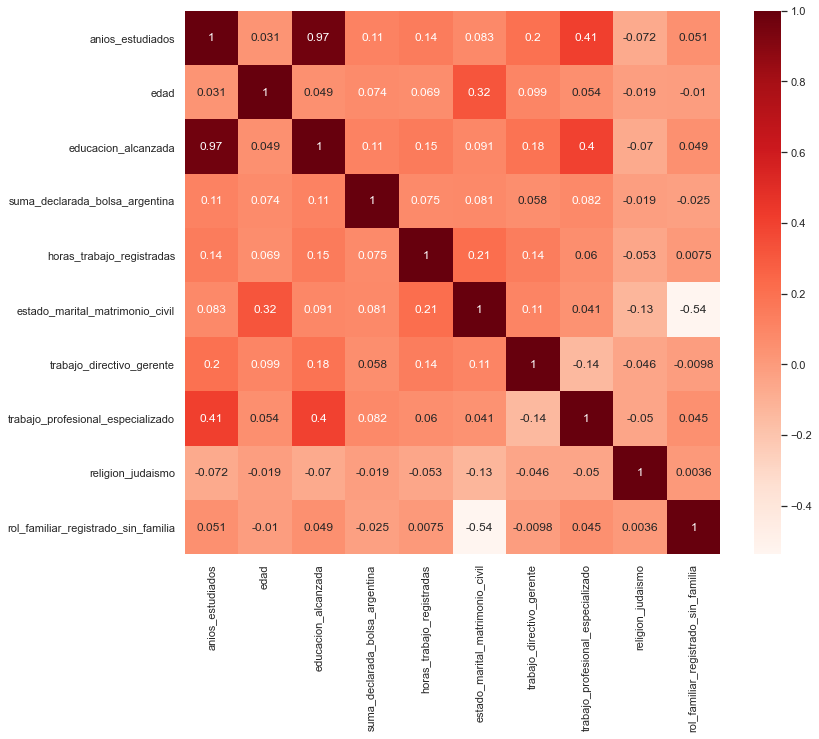

In [8]:
plt.figure(figsize=(12,10))
cor = X_reduced.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Buscando buen clusters

In [9]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import graficar_matriz_confusion
from preprocessing import conversion_numerica
from sklearn.feature_selection import RFECV

df, df_holdout = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df = conversion_numerica(X_df)

scaler = StandardScaler()
scaled = scaler.fit_transform(X_df)
X_df_scaled = pd.DataFrame(scaled, index=X_df.index, columns=X_df.columns)
X_df_scaled

# Acá, por ejemplo 1° modelo sé que estos eran buenos hiperparametros:
# TODO: idea para preprocesing:
# 1° Preprocessing con StandarScaller y OneHotEncoding => hallar best hiper, etc etc
# 2° Preprocessing busco Clusters en base a las features importances con el 1° preprocessing, divido bien y luego vuelvo a entrenar

clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth= 3, min_samples_leaf = 535, random_state=10)
selector = RFECV(
    estimator=clf,
    min_features_to_select=15,
    step=5,
    n_jobs=-1,
    scoring="f1",
    cv=5,
)
selector = selector.fit(X_df_scaled, y_df)

f = selector.get_support(1) 
X_reduced = X_df[X_df.columns[f]] 

X_reduced

,anios_estudiados,edad,educacion_alcanzada,suma_declarada_bolsa_argentina,horas_trabajo_registradas,genero_mujer,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_sin_matrimonio,estado_marital_viudo_a,trabajo_ejercito,trabajo_inspector,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a
0,17,39,5,2174,40,0,0,0,0,1,0,0,0,1,0
1,17,50,5,0,13,0,1,0,0,0,0,0,0,0,0
2,13,38,4,0,40,0,0,0,0,0,0,0,0,1,0
3,11,53,3,0,40,0,1,0,0,0,0,0,0,0,0
4,17,28,5,0,40,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,16,27,5,0,38,1,1,0,0,0,0,0,0,0,0
32557,13,40,4,0,40,0,1,0,0,0,0,0,1,0,0
32558,13,58,4,0,40,1,0,0,0,0,1,0,0,0,1
32559,13,22,4,0,20,0,0,0,0,1,0,0,0,0,0


In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_reduced)
y_kmeans = kmeans.predict(X_reduced)
y_kmeans

array([0, 0, 0, ..., 0, 0, 2])

# Reduzco dimensionalidad SIN EL MÉTODO DE RFE

In [11]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import graficar_matriz_confusion
from preprocessing import conversion_numerica
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

df, df_holdout = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df = conversion_numerica(X_df)

scaler = StandardScaler()
scaled = scaler.fit_transform(X_df)
X_df_scaled = pd.DataFrame(scaled, index=X_df.index, columns=X_df.columns)
X_df_scaled

pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(X_df_scaled)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))



Explained variation per principal component: [0.08330472 0.06251233]
Cumulative variance explained by 2 principal components: 14.58%


15% varianza mantenida, es un asco PCA!

Pero con MDS o Isomap no puedo ejecutar el codigo, me tarda un monton!!

Hablar con Axel y Juan esto!!

# Buscando K ideal para KMeans con feature_importance del arbol de decision entrenado

3. HyperTuning the Parameter for KMeans
Data shape:  (32561, 15)
Parameter: {'n_clusters': 2} Score 0.9861524274499055
Parameter: {'n_clusters': 3} Score 0.9385241325531977
Parameter: {'n_clusters': 4} Score 0.9334814906580444
Parameter: {'n_clusters': 5} Score 0.9343947218886267
Parameter: {'n_clusters': 8} Score 0.9554271831541751
Parameter: {'n_clusters': 10} Score 0.9584230074450966
Parameter: {'n_clusters': 20} Score 0.9430925443233497
Parameter: {'n_clusters': 30} Score 0.41497676171392583


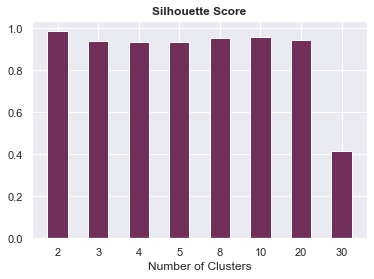

optimum num of clusters = 2


In [16]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score

def kmean_hyper_param_tuning(data):
    """
    Hyper parameter tuning to select the best from all the parameters on the basis of silhouette_score.

    :param data: dimensionality reduced data after applying PCA
    :return: best number of clusters for the model (used for KMeans n_clusters)
    """
    # candidate values for our number of cluster
    parameters = [2, 3, 4, 5, 8, 10, 20, 30]

    # instantiating ParameterGrid, pass number of clusters as input
    parameter_grid = ParameterGrid({'n_clusters': parameters})

    best_score = -1
    kmeans_model = KMeans()     # instantiating KMeans model
    silhouette_scores = []
    print("Data shape: ", data.shape)
    # evaluation based on silhouette_score
    for p in parameter_grid:
        kmeans_model.set_params(**p)    # set current hyper parameter
        kmeans_model.fit(data)          # fit model on wine dataset, this will find clusters based on parameter p

        ss = silhouette_score(data, kmeans_model.labels_)   # calculate silhouette_score
        silhouette_scores += [ss]       # store all the scores

        print('Parameter:', p, 'Score', ss)

        # check p which has the best score
        if ss > best_score:
            best_score = ss
            best_grid = p

    # plotting silhouette score
    plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
    plt.xticks(range(len(silhouette_scores)), list(parameters))
    plt.title('Silhouette Score', fontweight='bold')
    plt.xlabel('Number of Clusters')
    plt.show()

    return best_grid['n_clusters']



from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import graficar_matriz_confusion
from preprocessing import conversion_numerica
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

df, df_holdout = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df = conversion_numerica(X_df)

scaler = StandardScaler()
scaled = scaler.fit_transform(X_df)
X_df_scaled = pd.DataFrame(scaled, index=X_df.index, columns=X_df.columns)

clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth= 3, min_samples_leaf = 535, random_state=10)
selector = RFECV(
    estimator=clf,
    min_features_to_select=15,
    step=5,
    n_jobs=-1,
    scoring="f1",
    cv=5,
)
selector = selector.fit(X_df_scaled, y_df)

f = selector.get_support(1) 
X_reduced = X_df[X_df.columns[f]] 
 
print("3. HyperTuning the Parameter for KMeans")
optimum_num_clusters = kmean_hyper_param_tuning(X_reduced)
print("optimum num of clusters =", optimum_num_clusters)

No tiene mucho sentido sobre X_reduced segun ese arbol entrenado!

Lo ideal es hacerlo sin eso!!!

Pero KMeans no sirve mucho sin aplicar X_reduced.. habrá que probar DBSCAN o alguno de esos 